In [8]:
import pandas as pd
from pandasql import sqldf

# import CNV bed data as a dictionary, including four datasets: delCases/Controls, dupCases/Controls
filename = "ISC-r1.CNV.bed"
cnvbed = {}
dataset = None
for line in open(filename).readlines():
    if not line.startswith("chr"):
        dataset = line.strip().split()[1].lstrip("name=")
        cnvbed[dataset] = {}
        continue
    line = line.strip().split()
    if not line[0] in cnvbed[dataset]:
        cnvbed[dataset][line[0]] = []
    cnvbed[dataset][line[0]].append((int(line[1]),int(line[2])))
    
for dataset in cnvbed.keys():
    for chrom in cnvbed[dataset]:
        cnvbed[dataset][chrom].sort()
#print (cnvbed)

# transfer cnvbed from dictionary to data frame using pandas, includes four datasets
cnvbed_df = {}
for dataset in cnvbed.keys():
    cnvbed_df[dataset] = {"chrom":[], "cnv_start":[], "cnv_end":[]}
    for chrom in cnvbed[dataset]:
        start, end = tuple(zip(*cnvbed[dataset][chrom]))
        cnvbed_df[dataset]["chrom"].extend([chrom] * len(start))
        cnvbed_df[dataset]["cnv_start"] += list(start)
        cnvbed_df[dataset]["cnv_end"] += list(end)
    cnvbed_df[dataset] = pd.DataFrame.from_dict(cnvbed_df[dataset]).drop_duplicates(subset=("chrom", "cnv_start", "cnv_end"))
#print (cnvbed_df)

# import reference gene using pandas
ref_gene = pd.read_table("refGene.txt.gz", compression="gzip", sep="\t", header = None, usecols=(1,2,4,5,12), 
                            names = ["tx_name", "chrom", "tx_start", "tx_end", "gene_name"])

# ???min(tx_start) and max(tx_end) may be incorrect, since genes may not spread successively, for example, FAM72C
# SELECT gene_name, chrom, min(tx_start), max(tx_end)
query = """
SELECT gene_name, chrom, tx_start, tx_end 
FROM ref_gene 
GROUP by chrom, gene_name
"""
gene_df = sqldf(query).drop_duplicates(subset=("chrom", "tx_start", "tx_end"))
#gene_df = gene_df.rename(columns={"min(tx_start)": "gene_start", "max(tx_end)": "gene_end"})
gene_df = gene_df.rename(columns={"tx_start": "gene_start", "tx_end": "gene_end"})
#print (gene_df)
#gene_df.to_csv("gene_df.csv")

# use four CNV datasets for xxx
cnv_in_gene = {}
cnv_counts = {}
#cnv_count_table = {}
for name, value in cnvbed_df.items():
    # value contains four datasets, once in each loop, eg delCases
    query = """
    SELECT cnv.chrom, cnv.cnv_start, cnv.cnv_end, gene.gene_name
    FROM value cnv LEFT JOIN gene_df gene
    WHERE cnv.chrom == gene.chrom 
    AND (
    (cnv.cnv_start >= gene.gene_start AND cnv.cnv_start <= gene.gene_end)
    OR
    (cnv.cnv_end >= gene.gene_start AND cnv.cnv_end <= gene.gene_end)
    )
    """
    # ???drop duplicates: based on "gene_name", CNVs share same chromosome and start/end may named different gene
    # combine different gene names as long as CNVs share same chromosome and same start/end
    #      chrom,cnv_start,cnv_end,gene_name
    # 1569,chr1,142742006,145016146,FAM72C
    # 1570,chr1,142742006,145016146,LINC00623
    # 1571,chr1,142742006,145016146,LINC00869
    # 1572,chr1,142742006,145016146,LOC100132057
    # 1573,chr1,142742006,145016146,MIR5096
    # 1574,chr1,142742006,145016146,MIR6077
    # 1575,chr1,142742006,145016146,NBPF20
    # 1576,chr1,142742006,145016146,NBPF8
    # 1577,chr1,142742006,145016146,NBPF9
    # 1578,chr1,142742006,145016146,PDE4DIP
    # 1579,chr1,142742006,145016146,PPIAL4A
    # 1580,chr1,142742006,145016146,PPIAL4C
    # 1581,chr1,142742006,145016146,SRGAP2D
    cnv_in_gene[name] = value = sqldf(query)
    #cnv_in_gene[name] = value = sqldf(query).drop_duplicates(subset=("chrom", "cnv_start", "cnv_end", "gene_name"))
    
    # add chrom in GROUP BY, because microRNAs spread multiple chromosomes
    query = """
    SELECT chrom, gene_name, count(gene_name), cnv_start, cnv_end
    FROM value
    GROUP BY gene_name, chrom
    ORDER BY count(gene_name) DESC
    """
    # actually, do not need to drop duplicates, since duplicates have been dropped in previous step
    cnv_counts[name] = sqldf(query)

# print out file
#delcases = cnv_in_gene["delCases"]
#delcases.to_csv("test1.csv")

#print (cnv_in_gene["delCases"])
# question: microRNAs spread multiple chromosomes???
# question(below): same transcript may spread in different location in the same chrom, so does the corresponding gene
# 911	NR_121570	chr9	+	5	42771707,42778907,42779310,42781497,42782125,	42771789,42779058,42779714,42781634,42782614,	LOC101928381
# 1095	NR_121570	chr9	+	5	66922966,66930163,66930566,66932712,66933340,	66923048,66930314,66930970,66932849,66933829,	LOC101928381
# 1117	NR_121570	chr9	-	5	69746916,69747896,69749771,69750423,69757702,	69747405,69748033,69750175,69750574,69757784,	LOC101928381
# 1121	NR_121570	chr9	-	5	70364017,70364997,70366917,70367573,70374842,	70364506,70365134,70367321,70367724,70374924,	LOC101928381

#print (cnv_in_gene)
print (cnv_counts["delCases"], cnv_counts["delControls"])
print (sum(cnv_counts["delCases"]["count(gene_name)"]), sum(cnv_counts["delControls"]["count(gene_name)"]))
# cnv_count_table duplicates with cnv_counts
#print (cnv_count_table["delCases"], cnv_count_table["delControls"])


     chrom     gene_name  count(gene_name)  cnv_start    cnv_end
0     chr7        IMMP2L                26  110799758  110973658
1     chr1        NBPF20                18  145306080  146059433
2     chr6         PARK2                15  162866163  162983023
3    chr20       MACROD2                13   14845590   15014616
4    chr10        CTNNA3                12   68070424   68177220
5     chr1       AADACL3                 9   12787138   13011237
6     chr9        LINGO2                 9   28683159   28783888
7     chr7  LOC100128885                 9   64067525   64380212
8     chr4         GRID2                 7   94180230   94313389
9     chr4         DDX60                 6  169226351  169367172
10    chr4        DDX60L                 6  169226351  169367172
11   chr15         HERC2                 6   28563286   28767234
12    chr7         LRRN3                 6  110743162  110882041
13    chr1        NBPF10                 6  145306080  146059433
14    chr1       NBPF25P 

In [2]:
from pprint import pprint
pprint(cnv_in_gene)
#pprint([(x, y.keys()) for x,y in data.items()])

{'delCases':      chrom  cnv_start    cnv_end     gene_name
0    chr21   22333498   22460063         NCAM2
1    chr21   22561560   22854665         NCAM2
2    chr21   22696187   22854665         NCAM2
3    chr21   23413828   23560599  LOC101927843
4    chr21   23427801   23560599  LOC101927843
5    chr21   30822089   30988271         GRIK1
7    chr21   40136215   41208474     LINC00114
8    chr16   10469680   10644922          EMP2
9    chr16   10472949   10641976          EMP2
10   chr16   12238034   12399604         SNX29
11   chr16   15023758   16366867         NOMO3
12   chr16   15032942   15324012        NPIPA1
13   chr16   15148795   15324012         NTAN1
17   chr16   15168237   18084698        PDXDC1
19   chr16   15403541   16189809         ABCC1
20   chr16   21422575   21856859        NPIPB3
22   chr16   21500956   21746842          OTOA
24   chr16   21510499   21654018         IGSF6
27   chr16   21513553   21636716        METTL9
29   chr16   21693739   22335781        POLR3E


In [2]:
query = """
select gene_name, chrom, tx_start, tx_end
from ref_gene 
where gene_name = "LOC101928381"
"""
print (sqldf(query))

query = """
select gene_name, chrom, tx_start, tx_end
from ref_gene 
where gene_name = "FAM72C"
"""
print (sqldf(query))

      gene_name chrom  tx_start    tx_end
0  LOC101928381  chr9  42771707  42782614
1  LOC101928381  chr9  66922966  66933829
2  LOC101928381  chr9  69746916  69757784
3  LOC101928381  chr9  70364017  70374924
  gene_name chrom   tx_start     tx_end
0    FAM72C  chr1  143896524  143913160
1    FAM72C  chr1  206138439  206155074
2    FAM72C  chr1  143896524  143913160
3    FAM72C  chr1  143896524  143913160
4    FAM72C  chr1  143896524  143914673
5    FAM72C  chr1  143896524  143914673
6    FAM72C  chr1  143904508  143913160


[(0, 3)]

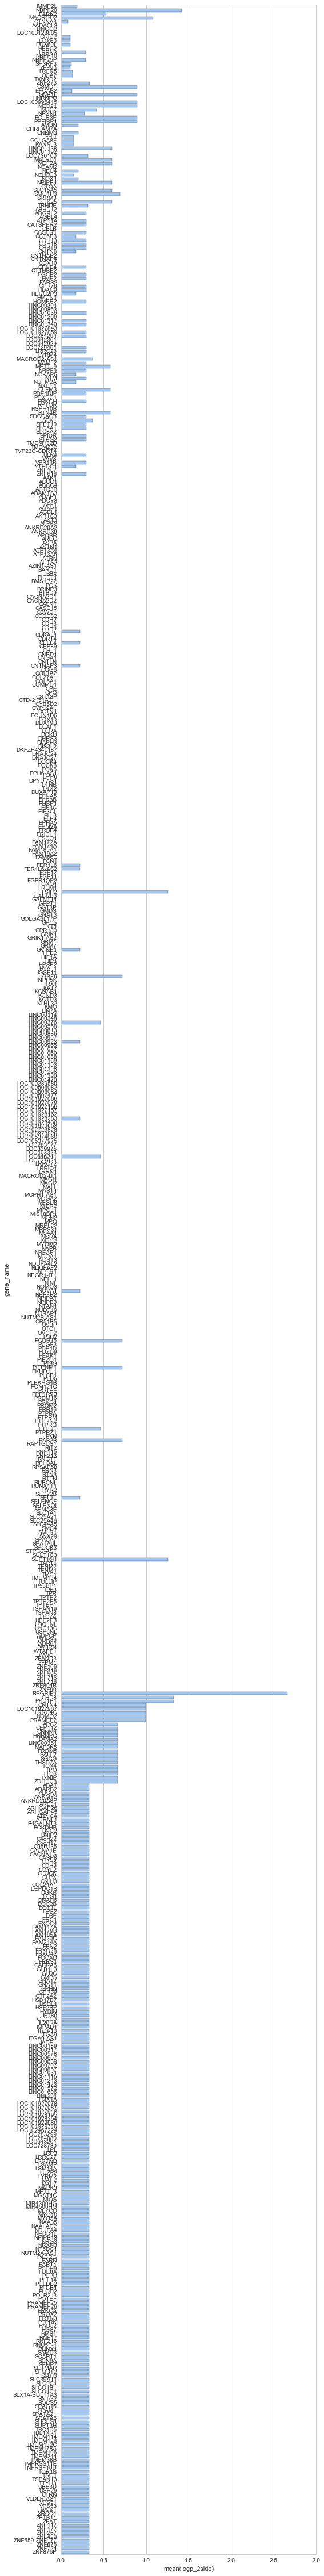

In [16]:
from fisher import pvalue
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#delCases = pd.DataFrame.transpose(cnv_counts["delCases"])
delCases = cnv_counts["delCases"]
delControls = cnv_counts["delControls"]
dupCases = cnv_counts["dupCases"]
dupControls = cnv_counts["dupControls"]
#print (delCases)
#print (delControls)

# http://stackoverflow.com/questions/29464234/compare-python-pandas-dataframes-for-matching-rows
# ???cnv_start and cnv_end needed? Sometimes, cnv start or end can differ up to millions of bps
#del_table = pd.merge(delCases, delControls, on = ["chrom", "gene_name", "cnv_start", "cnv_end"])
del_table = pd.merge(delCases, delControls, how = "outer", on = ["chrom", "gene_name"])
del_table["count(gene_name)_x"].fillna(0, inplace=True)
del_table["count(gene_name)_y"].fillna(0, inplace=True)
#dup_table = pd.merge(dupCases, dupControls, on = ["chrom", "gene_name", "cnv_start", "cnv_end"])
dup_table = pd.merge(dupCases, dupControls, how = "outer", on = ["chrom", "gene_name"])
dup_table["count(gene_name)_x"].fillna(0, inplace=True)
dup_table["count(gene_name)_y"].fillna(0, inplace=True)
#print (dup_table)

# ???not sure which numbers to use
#n_delCases = 1374; n_delCtrls = 1278; n_dupCases = 2228; n_dupCtrls = 1873
n_delCases = sum(cnv_counts["delCases"]["count(gene_name)"])
n_delCtrls = sum(cnv_counts["delControls"]["count(gene_name)"])
n_dupCases = sum(cnv_counts["dupCases"]["count(gene_name)"])
n_dupCtrls = sum(cnv_counts["dupControls"]["count(gene_name)"])
#print (n_dupCases)
del_table = del_table.rename(columns={"count(gene_name)_x": "n_delcase_gene", "count(gene_name)_y": "n_delctrl_gene"})
del_table["n_delcase_nogene"] = n_delCases - del_table["n_delcase_gene"]
del_table["n_delctrl_nogene"] = n_delCtrls - del_table["n_delctrl_gene"]
del_table = del_table[["gene_name", "n_delcase_gene", "n_delctrl_gene", "n_delcase_nogene", "n_delctrl_nogene"]]
#print (del_table)
p_2side = []
p_rside = []
gene_list = []
logp_2side = []
logp_rside = []
for index, row in del_table.iterrows():
    #print (row["n_delcase_gene"], row["n_delctrl_gene"], row["n_delcase_nogene"], row["n_delctrl_nogene"])
    p = pvalue(row["n_delcase_gene"], row["n_delctrl_gene"], row["n_delcase_nogene"], row["n_delctrl_nogene"])
    #print (p.two_tail)
    p_2side.append(p.two_tail)
    logp_2side.append(-np.log10(p.two_tail))
    p_rside.append(p.right_tail)
    logp_rside.append(-np.log10(p.right_tail))
    gene_list.append(row["gene_name"])
#print (logp_rside)

sns.set(style="whitegrid")
sns.set_color_codes("pastel")
f, ax = plt.subplots(figsize=(8, 80))
p_df = pd.DataFrame({"logp_2side": logp_2side, "logp_rightside": logp_rside, "gene_name": gene_list})
plot1 = sns.barplot(x="logp_2side", y="gene_name", data=p_df, label="log pvalue 2-sided", color="b")
ax.set(xlim=(0, 3))
p1 = plot1.get_figure()
p1.savefig("p1.png")
sns.set_color_codes("muted")
plot2 = sns.barplot(x="logp_rightside", y="gene_name", data=p_df, label="log pvalue right-sided", color="b")
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(xlim=(0, 3), ylabel="", xlabel="log10 p value two-sided and right-side (CNV deletion)")
sns.despine(left=True, bottom=True)
p2 = plot2.get_figure()
p2.savefig("p2.png")

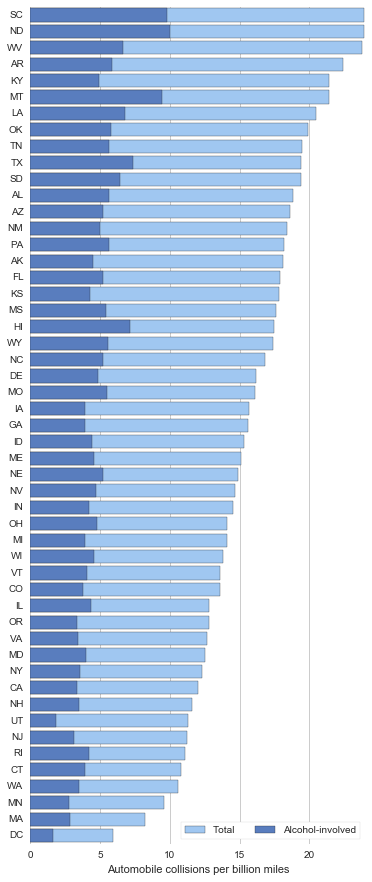

In [6]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))
# Load the example car crash dataset
crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)
#print (crashes)

# Plot the total crashes
sns.set_color_codes("pastel")
plt1 = sns.barplot(x="total", y="abbrev", data=crashes, label="Total", color="b")
#fig1 = plt1.get_figure()
#fig1.savefig("fig1.png")

# Plot the crashes where alcohol was involved, total crashes also showed in the plt2
sns.set_color_codes("muted")
plt2 = sns.barplot(x="alcohol", y="abbrev", data=crashes, label="Alcohol-involved", color="b")
# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="", xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)


In [128]:
p=[1,3,4,54,5,6,7,87,9.576]
a = ",".join(map(str, p))
b= tuple(p)
b[0]+b[8]

10.576